In [159]:
import numpy as np

import torch
from torch import optim

from livelossplot import PlotLosses

import sys
sys.path.insert(0, '../01_code')
from simple_Hamiltonian_systems import HarmonicOscillator
from main_simple_Hamiltonian_systems import plot_Ham_sys

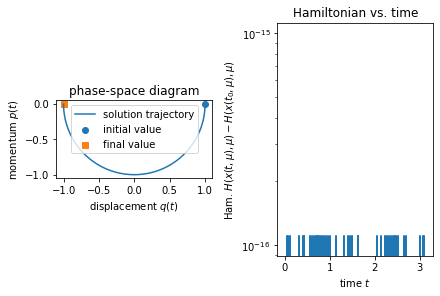

In [160]:
## Harmonic oscillator
model = HarmonicOscillator()
mu = {'m': 1., 'k': 1., 'f': 0., 'q0': 1., 'p0': 0.}
# compute solution for all t in [0, pi]
X, t = model.solve(0, np.pi, np.pi/1e3, mu)
all_Ham = model.Ham(X, mu)
# plot solution
plot_Ham_sys(X, t, all_Ham)

In [161]:
n = 10000 # number of training points
dt = 0.1 # time step

# generate random phase points in [-2,2]x[-2,2]
X_train = np.random.uniform(-2, 2, size=(n,2))

def time_step(x_train):
    # compute one time step h
    mu = {'m': 1., 'k': 1., 'f': 0., 'q0': x_train[0], 'p0': x_train[1]}
    y_train, _ = model.solve(0, dt+dt, dt, mu) # open time interval, therefore `dt+dt`

    return y_train[:,1]

Y_train = np.apply_along_axis(time_step, 1, X_train)

# convert to `torch.tensor`
torch.set_default_dtype(torch.float64)
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

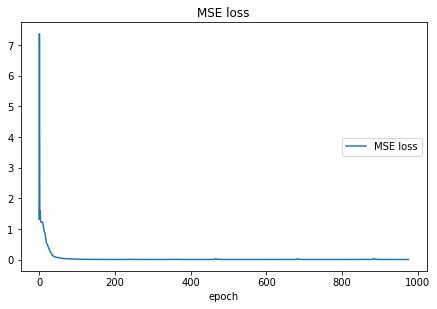

MSE loss
	MSE loss         	 (min:    0.000, max:    1.315, cur:    0.000)


In [162]:
# train basic FNN

nn_model = torch.nn.Sequential(
    torch.nn.Linear(2, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 2)
)

loss_fn = torch.nn.MSELoss()

learning_rate = 1e-1

opt = optim.Adam(nn_model.parameters(), lr=learning_rate)

liveloss = PlotLosses()

for t in range(1000):
    Y_pred = nn_model(X_train)

    loss = loss_fn(Y_pred, Y_train)

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model.
    loss.backward()

    opt.step()
    opt.zero_grad()

    liveloss.update({'MSE loss': loss.item()})

    if (t % 25) == 0:
        liveloss.send()

In [163]:
q0 = 1.
p0 = 0.

t_curr = 0.
t_end = np.pi

q_curr = q0
p_curr = p0
nn_X = np.array([[q_curr, p_curr]])

while t_curr < t_end:
    y = nn_model(torch.tensor([[q_curr, p_curr]]))
    q_curr = y.data[0][0].item()
    p_curr = y.data[0][1].item()

    nn_X = np.append(nn_X, np.array([[q_curr, p_curr]]), axis=0)

    t_curr += dt

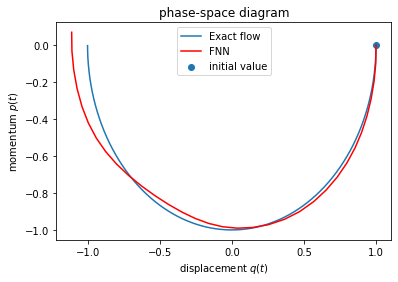

In [167]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.plot(X[0,:], X[1,:], label='Exact flow')
ax.plot(nn_X[:,0], nn_X[:,1], 'r', label='FNN')
ax.scatter(X[0,0], X[1,0], marker='o', label='initial value')
ax.set_xlabel(r'displacement $q(t)$')
ax.set_ylabel(r'momentum $p(t)$')
ax.legend()
ax.set_title('phase-space diagram')

fig.show()